In [23]:
#Load modules

import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd

from numpy.random import choice 
from numpy import where, power


In [20]:
geo = 'CHI_COM'

var_dict = {'name': ['Wages', 'Output', 'Exports', 'Imports'], 
       'dataset': ['prd','prd', 'trd', 'trd'], 
       'levels': [['CI1', 'CI2', 'CI4'],['CI1', 'CI2', 'CI4'], ['HS1', 'HS2', 'HS4'], ['HS1', 'HS2', 'HS4']],
#            'agg_ref' : [CIIU, CIIU, HS, HS],
           'agg_str' : ['CIIU','CIIU', 'HS', 'HS']}

hard_drive_path = './../../../../../media/miglesia/Elements/Matias_Iglesias_Backup/miglesia/Documents/compute-corr-structures/'
path = 'data/disagg_struct_refs/formatted/'


# GEO_chi = pd.read_csv('data/disagg_struct_refs/formatted/GEO_chi.csv')

def add_theme_attribute_column(nodes):

    node_attribute_datasets = []

    for ds in datasets:
        df = nodes[[col for col in nodes.columns if ds['ID'][:-3] in col]]

        if len(set(df.columns)) > 1: #two variables in this dataset are on diff levels

            df_x = df.merge(ds['ref'].drop_duplicates(subset = df.columns[0]), 
                            on  = df.columns[0], how = 'left', suffixes=('_x', ''))
            df_x['att_B_x'] = df_x[ds['ID']].map(ds['dict'])

            df_y = df.merge(ds['ref'].drop_duplicates(subset = df.columns[1]), 
                            on  = df.columns[1], how = 'left', suffixes=('_x', ''))
            df_y['att_B_y'] = df_y[ds['ID']].map(ds['dict'])

            # Column with values of thematic labels, from entries of 'HS' ('CIIU') dataset
#             df_ds = df_x[['att_B_x']].fillna(df_y[['att_B_y']])
            df_ds = pd.DataFrame(where(df_x.att_B_x.isnull(), df_y.att_B_y, df_x.att_B_x), columns = ['att_B'])

        else:
            df_ = df.merge(ds['ref'].drop_duplicates(subset = df.columns[0])
                           , how = 'left')
            df_ds = pd.DataFrame(df_[ds['ID']].map(ds['dict']))

        df_ds.columns = ['att_B']

        node_attribute_datasets += [df_ds]
#         print len(df_ds)

    att_B = node_attribute_datasets[0].fillna(node_attribute_datasets[1])

    nodes['att_B'] = att_B.fillna('Others')
    
    return nodes

CIIU = pd.read_csv(path+'CIIU_full.csv')
HS = pd.read_csv(path+'hs_full.csv').astype(str)
HS[[col for col in HS.columns if 'HS ID' in col]] = HS[[col for col in HS.columns if 'HS ID' in col]].astype('int')

HS_cats_dict = {1: 'Vegetables, animals, wood', 2: 'Vegetables, animals, wood', 3: 'Vegetables, animals, wood', 
     4: 'Vegetables, animals, wood', 9: 'Vegetables, animals, wood', 10: 'Vegetables, animals, wood', 
     5: 'Minerals, metals', 14: 'Minerals, metals', 15: 'Minerals, metals',  
     11: 'Textiles', 12: 'Textiles',
     16: 'Manufacture, machinery', 17: 'Manufacture, machinery', 18: 'Manufacture, machinery', 19: 'Manufacture, machinery', 20: 'Manufacture, machinery'}
CIIU_cats_dict = {'A': 'Vegetables, animals, wood', 'B': 'Minerals, metals', 'C': 'Fabrication', 'G': 'Commerce', 'O': 'Public sector'}


datasets = [{'ref': HS,'ID':'HS ID HS1', 'dict': HS_cats_dict},
               {'ref': CIIU, 'ID':'CIIU ID CI1', 'dict': CIIU_cats_dict }]

nodes = nodes.sort_index()

rainbow_colors = {1:'#9400D3', #Violet
2:'#4B0082', #Indigo
3:'#0000FF', #Blue
4:'#00FF00', #Green
5:'#D3D3D3', #Gray
6:'#FFFF00', #Yellow
7:'#FF7F00', #Orange
8:'#FF0000'} #Red

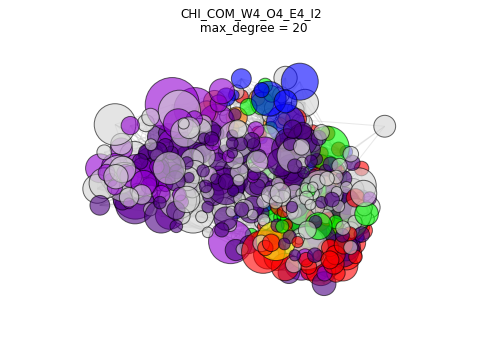

In [29]:
import networkx as nx

max_d = 10
k = 0.05
max_degrees = [4, 7, 10, 20, 40]
k = [.02, .05, 0.09, .11, .15]
k = [.02, .05, 0.06, .10, .16]
l = len(max_degrees)


# files = glob.glob('./Figures/6_neighbhoods/*')
path = 'data/new/'

conf = ('CI4', 'CI4', 'HS4', 'HS2')

#     (CIIU_lev, HS_Exp, HS_Imp) = conf
#     (CBO_lev, CNAE_lev, HS_Exp, HS_Imp) = conf

#     col_name = ctry_str+'_'+geo_str+'_'+'_'.join([c for c in conf])+var_str
conf_name = geo+'_'+'_'.join([var_dict['name'][m][0]+conf[m][2::2] for m in range(len(var_dict['name']))])

#             print conf_name

nodes = pd.read_csv(hard_drive_path+path+conf_name+'_nodes.csv', index_col = 0).sort_index().reset_index()
edges = pd.read_csv(hard_drive_path+path+conf_name+'_edges.csv', index_col = 0)[['label_x', 'label_y', 'weight_CHI_COM']]
edges = edges.merge(nodes['node_name'].reset_index(), left_on='label_x', right_on='node_name').merge(
    nodes['node_name'].reset_index(), left_on='label_y', right_on='node_name')[['index_x', 'label_x', 'index_y', 'label_y', 'weight_CHI_COM']]



    #     Add info of districts with most volume (CHI)
###
# From concat data get node value totals

df = pd.read_csv(hard_drive_path+path+conf_name+'_cc_data.csv', index_col = 'node_name')
df['node_value_USD'] = df.groupby('node_name')[['value_USD']].sum()

df = df.reset_index()

#     ###

#color
from matplotlib import colors

nodes = add_theme_attribute_column(nodes) #add gross thematic attributes, function is written below

nodes['color_code'] = nodes.att_B.rank(method = 'dense') #or att_B

nodes['color'] = pd.DataFrame(nodes['color_code'].map(rainbow_colors))

value = nodes['node_value_USD']
# nodes['node_size'] = np.sqrt((value/value.median()).values)
nodes['node_size'] = power((value/value.median()).values, 1/2.)
nodes['node_size'] = 30*nodes['node_size']/nodes['node_size'].median()

#     nodes = nodes.merge(code_hex)
max_d = 20

        ### Max degree = max_d. Parameter used to trim the network.
df1 = edges.groupby('index_x').apply(lambda x: x.nlargest(max_d, 'weight_'+geo)).reset_index(drop = True)
df2 = edges.groupby('index_y').apply(lambda x: x.nlargest(max_d, 'weight_'+geo)).reset_index(drop = True)
edges_max_d = df1.merge(df2, on = ['index_x', 'index_y', 'weight_'+geo]).reset_index(drop = True)

###

G = nx.from_pandas_dataframe(edges_max_d, 'index_x', 'index_y', 'weight_'+geo)

# Subset of nodes
nodes_s = nodes.loc[G.nodes()]



#Perform Graph Drawing

pos = nx.spring_layout(G, k=.1)

plt.figure(10, 8)

nx.draw(G, pos, node_size = nodes_s.node_size.values, alpha=.6, node_color= list(nodes_s.color.values), edgelist = [])
nx.draw_networkx_edges(G, pos, edge_color='.7', alpha=.3)
plt.title('max_d = '+str(max_d))
plt.title(conf_name+'\n max_degree = '+str(max_d))
#     plt.savefig('./Figures/5_max_deg/'+col_name+'_plot1.png')
#             plt.show()

plt.show()




In [34]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

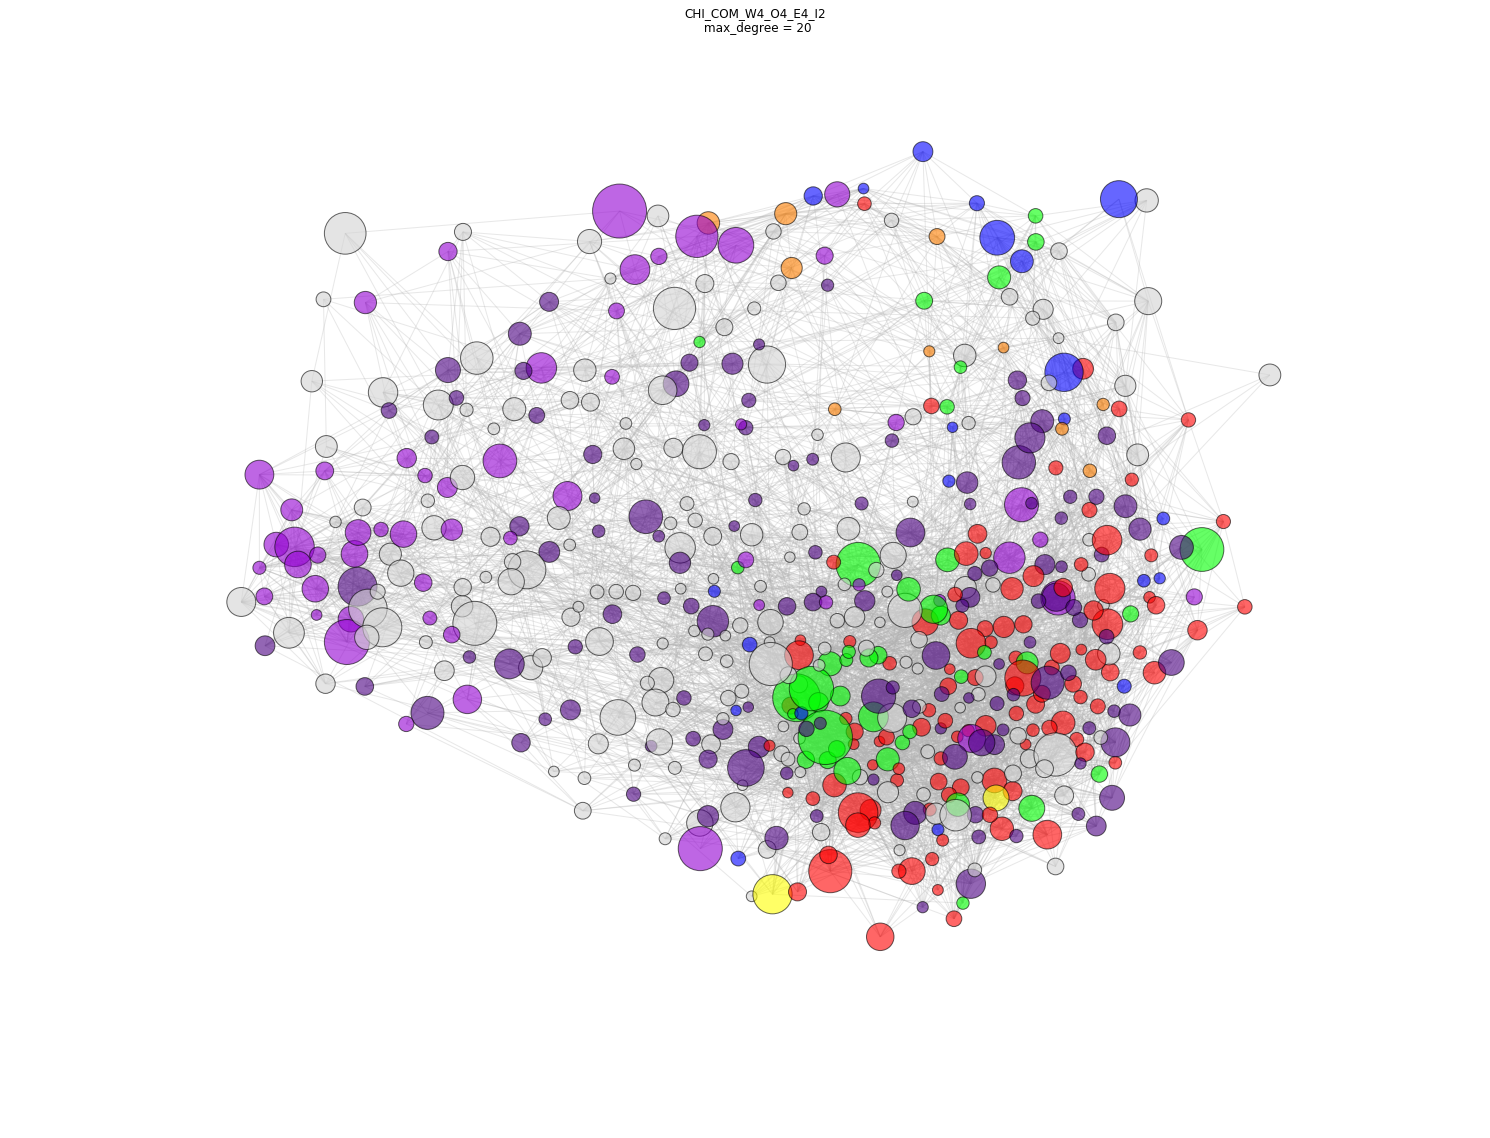

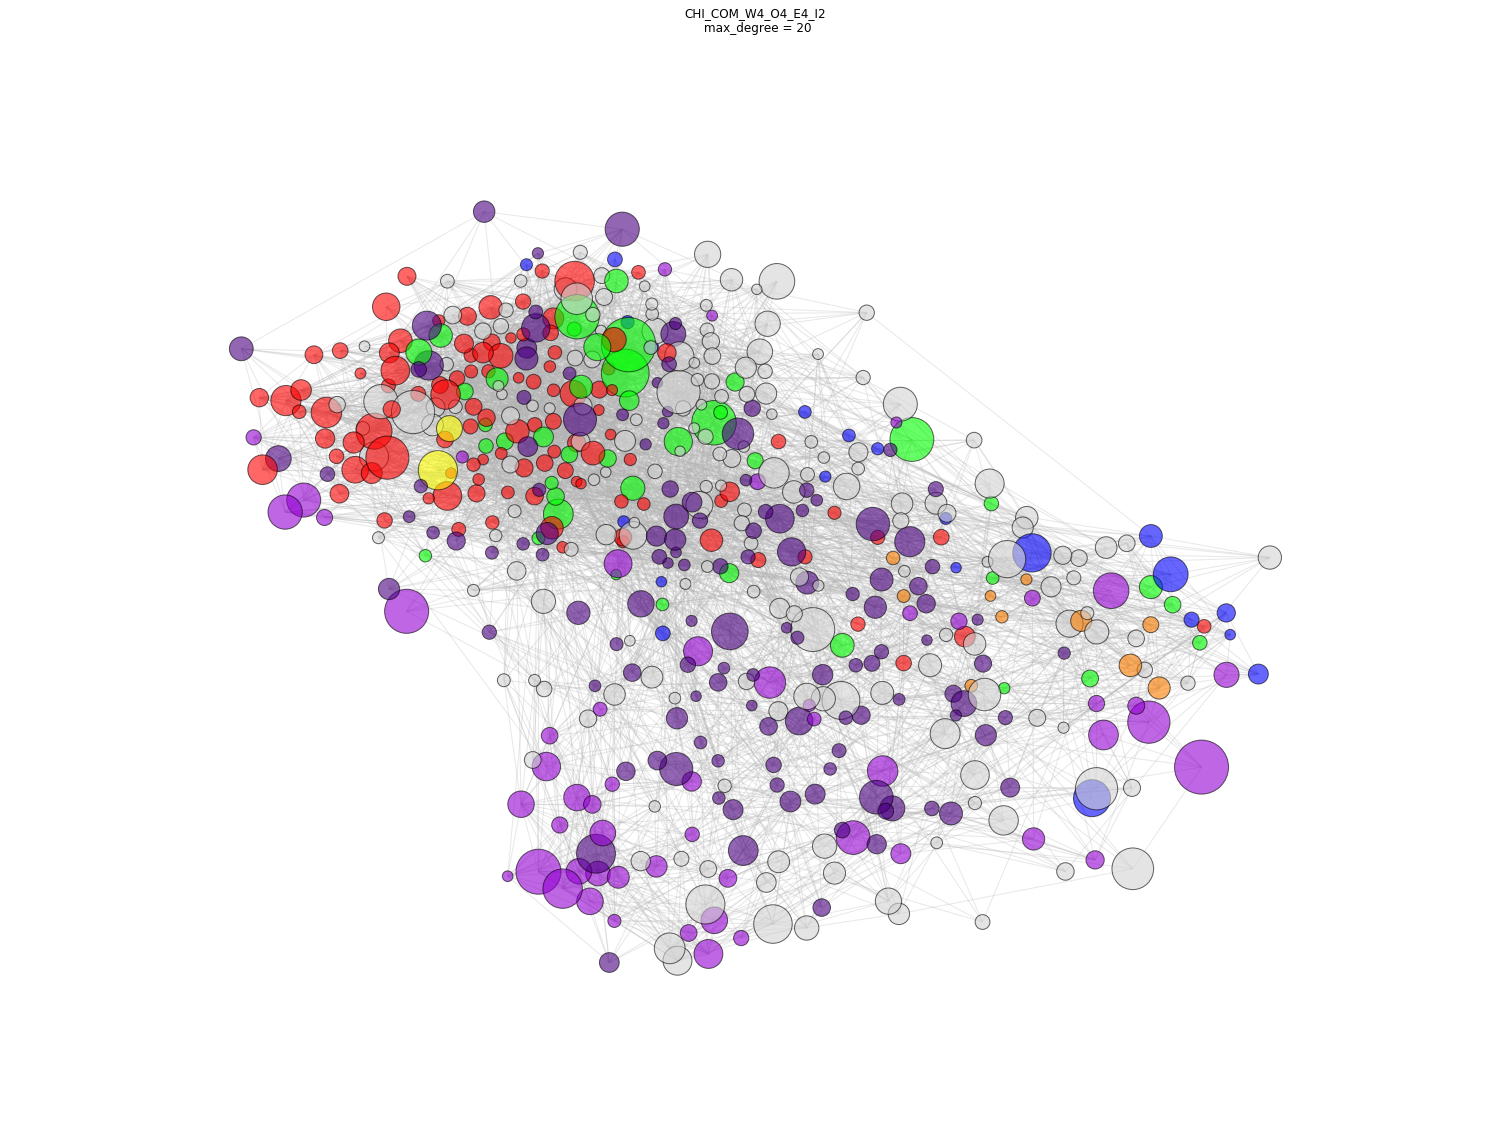

In [53]:
for k in [.15, .1]:
    pos = nx.spring_layout(G, k = k)
    plt.figure(figsize = (20, 15))

    nx.draw(G, pos, node_size = nodes_s.node_size.values, alpha=.6, node_color= list(nodes_s.color.values), edgelist = [])
    nx.draw_networkx_edges(G, pos, edge_color='.7', alpha=.3)
    plt.title('max_d = '+str(max_d))
    plt.title(conf_name+'\n max_degree = '+str(max_d))
    #     plt.savefig('./Figures/5_max_deg/'+col_name+'_plot1.png')
    #             plt.show()

    plt.show()

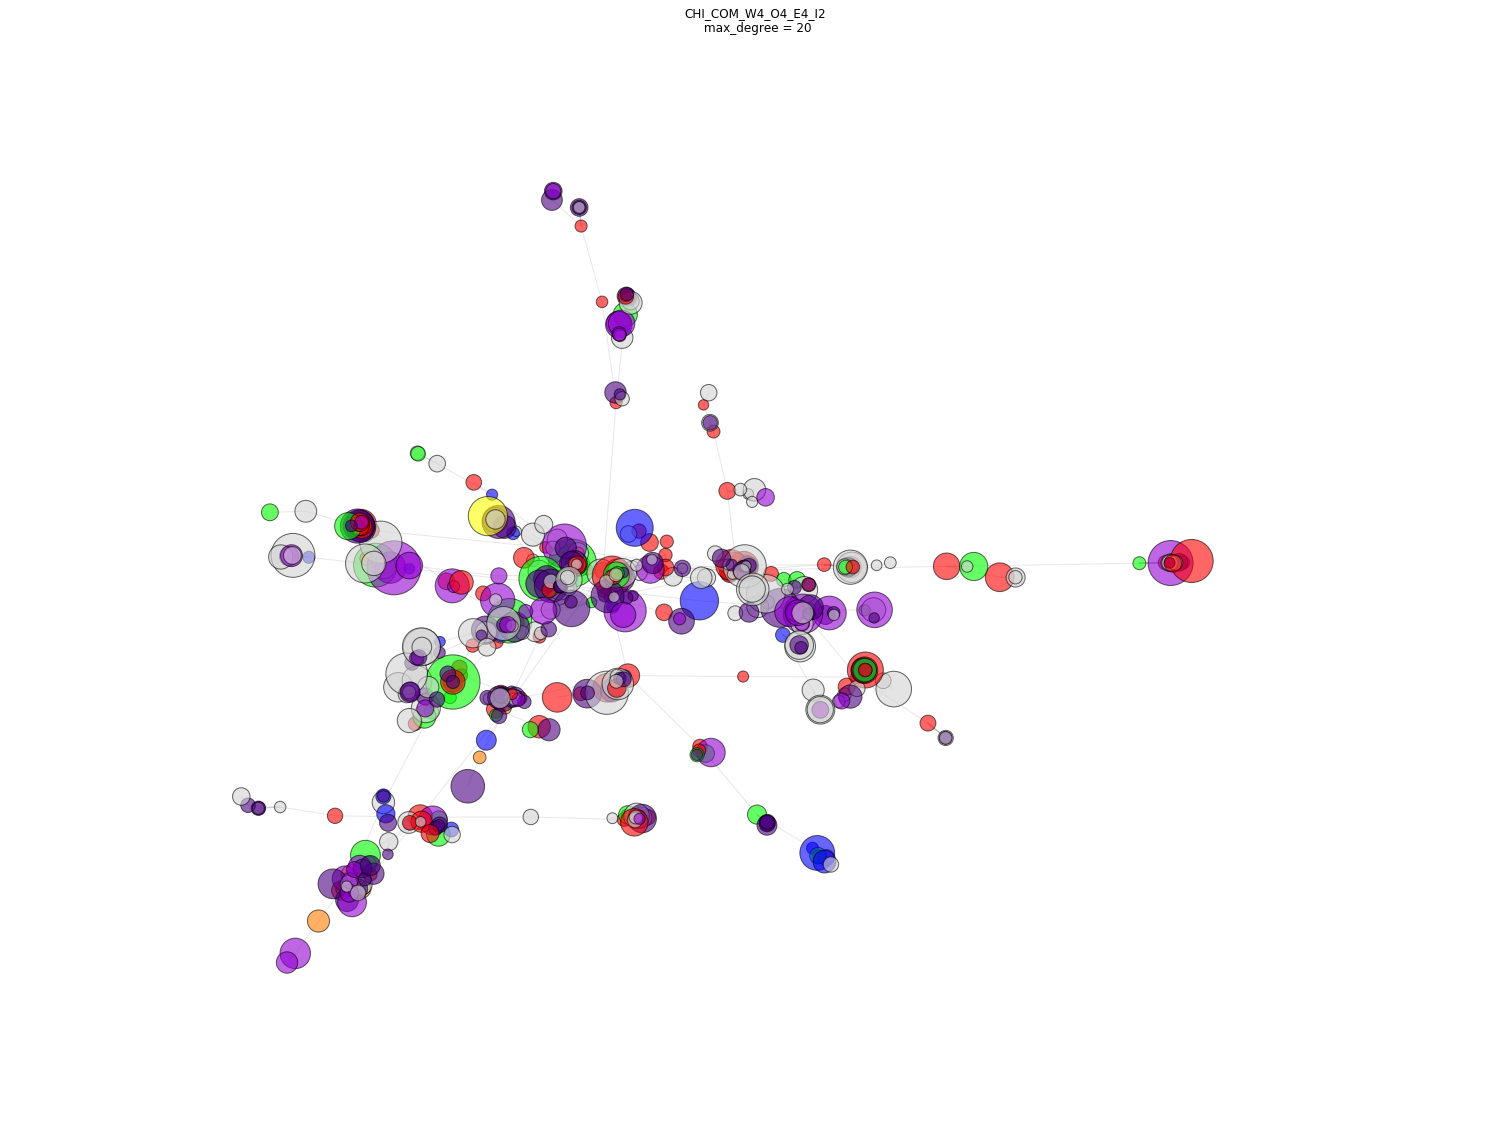

In [45]:
# G_mst = nx.minimum_spanning_tree(G)

pos = nx.spring_layout(G_mst, k=.0005)

plt.figure(figsize = (20, 15))

nx.draw(G_mst, pos, node_size = nodes_s.node_size.values, alpha=.6, node_color= list(nodes_s.color.values), edgelist = [])
nx.draw_networkx_edges(G_mst, pos, edge_color='.7', alpha=.3)
plt.title('max_d = '+str(max_d))
plt.title(conf_name+'\n max_degree = '+str(max_d))
#     plt.savefig('./Figures/5_max_deg/'+col_name+'_plot1.png')
#             plt.show()

plt.show()